---

# Libraries

In [266]:
import re
import eli5
import spacy
import nltk.stem
import nltk as nl
import pandas as pd
import xgboost as xgb
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV
from nltk import word_tokenize
from nltk.util import ngrams
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.tokenize import RegexpTokenizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import clone
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scikitplot.metrics import plot_confusion_matrix
import scikitplot.metrics
from sklearn.preprocessing import FunctionTransformer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
#nl.download('stopwords')
%matplotlib inline

---

# Data Loading & Pre-Processing

In [268]:
df = pd.read_csv("fake_or_real_news_training.csv") 

In [269]:
df.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


In [270]:
df.dtypes

ID        int64
title    object
text     object
label    object
X1       object
X2       object
dtype: object

## Check for Missing Value & Data Cleaning 

In [271]:
#Checking if target variable is equally distributed
df['label'].value_counts() #is equally distributed but needs additional data cleaning

REAL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [41]:
df = df[df['label'].map(len) == 4]

In [42]:
df['label'].value_counts() #cleaned

REAL    1990
FAKE    1976
Name: label, dtype: int64

## Calculating & Examining Title & Text Length

In [272]:
df['text_length'] = df['text'].apply(len)
df.head()

,ID,title,text,label,X1,X2,text_length
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN,7518
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN,2646
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN,2543
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN,2660
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN,1840


In [273]:
df['title_length'] = df['title'].apply(len)
df.head()

,ID,title,text,label,X1,X2,text_length,title_length
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN,7518,28
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN,2646,85
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN,2543,43
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN,2660,84
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN,1840,48


In [274]:
df[df["label"]=="FAKE"]["title_length"].mean()

69.62803643724696

In [275]:
df[df["label"]=="REAL"]["title_length"].mean()

61.08844221105527

In [276]:
df[df["label"]=="FAKE"]["text_length"].mean()

4110.713056680162

In [277]:
df[df["label"]=="REAL"]["text_length"].mean()

5294.0170854271355

As it can be seen the average length of real articles (5294) differs signifcantly from the ones of fake articles (4110). Consequently, in the later process I will parse the length of each article as a feature to the classifiers to see whether it will improve accuracy.

## Concating Title and Text, Deleting Informative Columns

In [278]:
df["total"] = df["title"] + df["text"]
df.head()

,ID,title,text,label,X1,X2,text_length,title_length,total
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN,7518,28,"You Can Smell Hillary’s FearDaniel Greenfield,..."
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN,2646,85,Watch The Exact Moment Paul Ryan Committed Pol...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN,2543,43,Kerry to go to Paris in gesture of sympathyU.S...
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN,2660,84,Bernie supporters on Twitter erupt in anger ag...
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN,1840,48,The Battle of New York: Why This Primary Matte...


In [279]:
df['X1'].value_counts()

REAL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [280]:
df['X2'].value_counts()

FAKE    1
REAL    1
Name: X2, dtype: int64

In [281]:
df = df.drop(columns=['X1', 'X2'])

## Train-Test-Split

In [282]:
train, test = train_test_split(df, test_size=0.20, random_state=42)

In [283]:
train.head()

,ID,title,text,label,text_length,title_length,total
1575,8373,WW3 averted? Putin congratulates Trump! [Video],"\nNovember 10th, 2016 - Fort Russ News - \nRT-...",FAKE,425,47,WW3 averted? Putin congratulates Trump! [Video...
506,6113,The World Is About To Witness A Breathtaking O...,"31 GOLD , KWN King World News \nOn the heels...",FAKE,8154,68,The World Is About To Witness A Breathtaking O...
3593,6764,Washington’s Intent is Economic Destabilizatio...,By Stephen Lendman\nVenezuela’s oil-dependent ...,FAKE,5462,80,Washington’s Intent is Economic Destabilizatio...
3562,3175,3 winners and 2 losers from Saturday night's R...,One might have expected the ninth Republican p...,REAL,13408,62,3 winners and 2 losers from Saturday night's R...
3220,2577,"Cost, logistics of Obama immigration plan rais...",President Obama’s executive action sparing mil...,REAL,3471,70,"Cost, logistics of Obama immigration plan rais..."


____

# Baseline

As we have a reasonable amount of data, a training set of almost 4000 entries, I decided to test the following algorithms because they work well given a resonable amount of data:

- Support Vector Machine (SVM)
- Logistic Regression
- Stochastic Gradient Descent (SGD)
- Passive Aggressive Classifier (PA)
- Random Forest (RF)
- XGBoost (XGB)
- Multi-layer Perceptron (MLP)
- Naive Bayes (NB)

I also included a Naive Bayes (NB) to benchmark with the other algorithms, because a NB usually works well with a lower amount of data. In fact it will turn out that NB performed better than some of the other algorithms but also turned out to be not among the top performers which was to be expected thanks to the reasonably sized training data set.

To transform the text into an input which a machine and algorithm can understand, I decided to use two of the most commong techniques: "Bag of Words" and "TF-IDF" weighing. 

Bag of Words simply counts the occureces of each word in the document, while TF-IDF weighing takes into account that there are few frequent words and very many very rare terms. As rare terms are more informative than frequent terms, TF-IDF weighing weighs them in arachnocentrically. "A high weight in tf–idf is reached by a high term frequency (in the given document) and a low document frequency of the term in the whole collection of documents; the weights hence tend to filter out common terms." (https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

By defaults both, CountVectorizer and TF-IDF vectorizer, put all the letters in lower case, which is a common step to be undertaken, and use a prebuild tokenizer. 
To account for terms that do not appear in the training but in the test dataset, LaPlace smoothing is set on true by default as well in the TF-IDF vectorizer as well.

In [49]:
KEYS = {
    "SEED": 1,
    "ITERATIONS": 500,
}

## Bag of Words a.k.a. Count Vectorizer

### SVM

In [116]:
svm_cnt_clf = Pipeline([('tfidf', CountVectorizer()), 
                     ('clf', svm.SVC())])

svm_cnt_clf = svm_cnt_clf.fit(train.total, train.label)

/Users/chrs/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy 0.8224181360201511


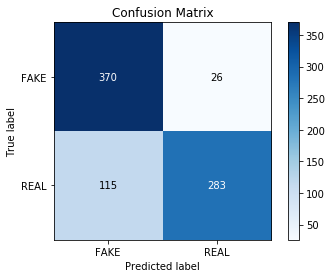

In [117]:
predicted = svm_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

### Naive Bayes

In [91]:
NB_cnt_clf = Pipeline([('tfidf', CountVectorizer()), 
                     ('clf', MultinomialNB())])

NB_cnt_clf = NB_cnt_clf.fit(train.total, train.label)

accuracy 0.889168765743073


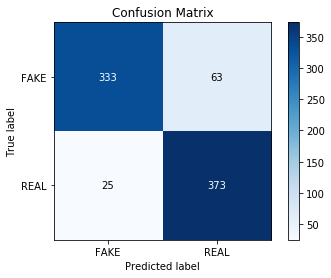

In [94]:
predicted = NB_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

### Logistic Regression

In [96]:
logit_cnt_clf = Pipeline([('tfidf', CountVectorizer()), 
                     ('clf', LogisticRegression(solver="lbfgs", max_iter=KEYS["ITERATIONS"], random_state=KEYS["SEED"]))])

logit_cnt_clf = logit_cnt_clf.fit(train.total, train.label)

accuracy 0.906801007556675


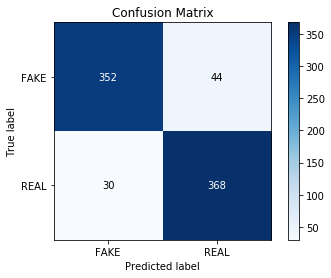

In [97]:
predicted = logit_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

### SGDClassifier

In [98]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer()), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.9193954659949622


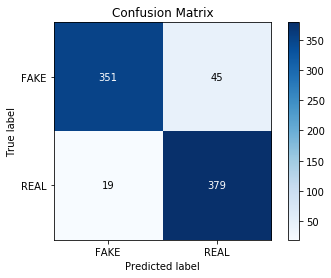

In [99]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

### PassiveAgressiveClassifier

In [18]:
pa_cnt_clf = Pipeline([('tfidf', CountVectorizer()), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_cnt_clf = pa_cnt_clf.fit(train.total, train.label)

accuracy 0.9042821158690176


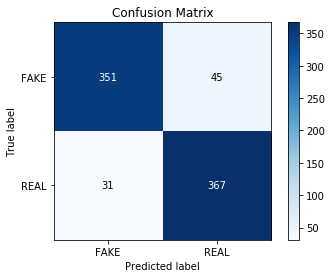

In [19]:
predicted = pa_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

### Random Forrest

In [10]:
rf_cnt_clf = Pipeline([('tfidf', CountVectorizer()), 
                     ('clf', RandomForestClassifier(random_state=KEYS["SEED"]))])

rf_cnt_clf = rf_cnt_clf.fit(train.total, train.label)

/Users/chrs/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy 0.8


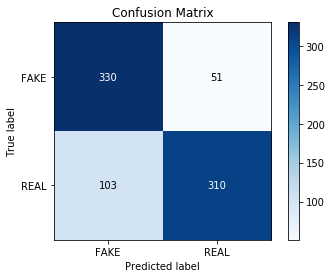

In [11]:
predicted = rf_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

### XGBoost

In [12]:
xgb_cnt_clf = Pipeline([('tfidf', CountVectorizer()), 
                     ('clf', xgb.XGBClassifier(random_state=KEYS["SEED"]))])

xgb_cnt_clf = xgb_cnt_clf.fit(train.total, train.label)

accuracy 0.88375


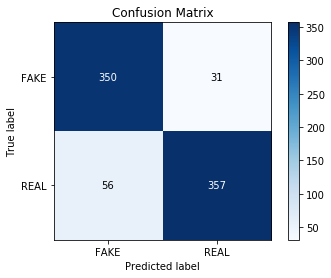

In [13]:
predicted = xgb_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

### MLP

In [16]:
mlp_cnt_clf = Pipeline([('tfidf', CountVectorizer()), 
                     ('clf', MLPClassifier(random_state=KEYS["SEED"]))])

mlp_cnt_clf = mlp_cnt_clf.fit(train.total, train.label)

accuracy 0.89875


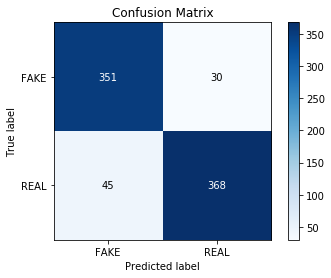

In [17]:
predicted = mlp_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

## TF-IDF

### SVM

In [284]:
svm_clf = Pipeline([('tfidf', TfidfVectorizer()), 
                     ('clf', svm.SVC())])

svm_clf = svm_clf.fit(train.total, train.label)

/Users/chrs/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy 0.47625


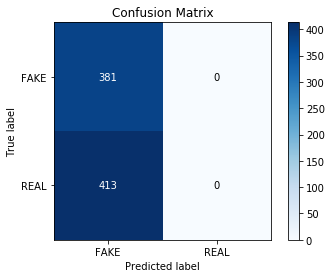

In [285]:
predicted = svm_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

Interestingly, SVM does not seem to be able to work with a TF-IDF matrix at all, as i classifies everything as FAKE which obviosly leads to a terrible score. If we could not test more algorithms, I would conduct some research why that is but since we have other pretty strong performing baseline algorithms, I will focus on those.

### Naive Bayes

In [105]:
NB_clf = Pipeline([('tfidf', TfidfVectorizer()), 
                     ('clf', MultinomialNB())])

NB_clf = NB_clf.fit(train.total, train.label)

accuracy 0.7695214105793451


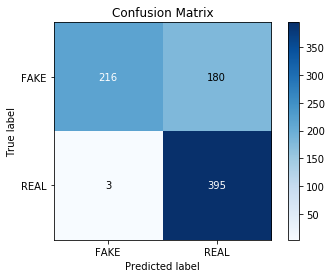

In [108]:
predicted = NB_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

### Logistic Regression

In [109]:
logit_clf = Pipeline([('tfidf', TfidfVectorizer()), 
                     ('clf', LogisticRegression(solver="lbfgs", max_iter=KEYS["ITERATIONS"], random_state=KEYS["SEED"]))])

logit_clf = logit_clf.fit(train.total, train.label)

accuracy 0.9168765743073047


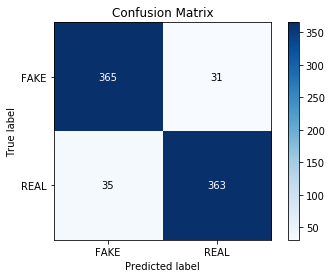

In [111]:
predicted = logit_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

### SGDClassifier

In [112]:
sgd_clf = Pipeline([('tfidf', TfidfVectorizer()), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_clf = sgd_clf.fit(train.total, train.label)

accuracy 0.9118387909319899


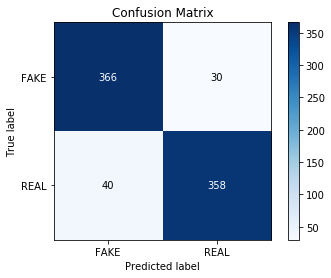

In [114]:
predicted = sgd_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

### PassiveAgressiveClassifier

In [342]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer()), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

accuracy 0.9307304785894207


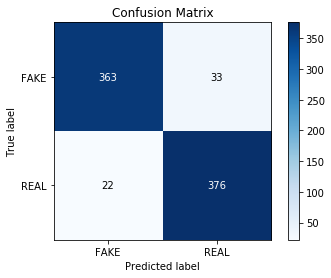

In [343]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

### Random Forrest

In [20]:
rf_clf = Pipeline([('tfidf', TfidfVectorizer()), 
                     ('clf', RandomForestClassifier(random_state=KEYS["SEED"]))])

rf_clf = rf_clf.fit(train.total, train.label)

/Users/chrs/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy 0.795


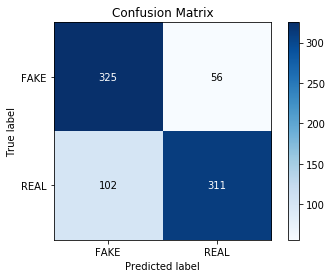

In [21]:
predicted = rf_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

### XGBoost

In [18]:
xgb_clf = Pipeline([('tfidf', TfidfVectorizer()), 
                     ('clf', xgb.XGBClassifier(random_state=KEYS["SEED"]))])

xgb_clf = xgb_clf.fit(train.total, train.label)

accuracy 0.8775


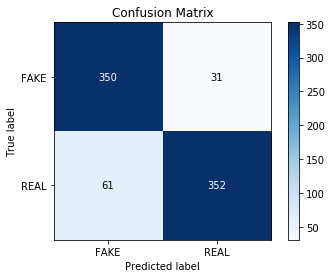

In [19]:
predicted = xgb_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

### MLP

In [22]:
mlp_clf = Pipeline([('tfidf', TfidfVectorizer()), 
                     ('clf', MLPClassifier(random_state=KEYS["SEED"]))])

mlp_clf = mlp_clf.fit(train.total, train.label)

accuracy 0.92375


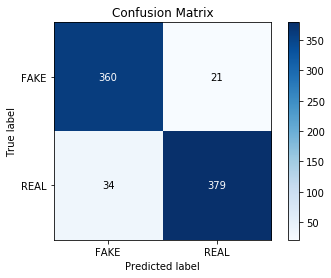

In [23]:
predicted = mlp_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

**The baseline models which performed the best were** 
- The SGD Classifier with bag of work Tokenization ~91.9 Accuracy
- The PassiveAggressive Classifier with TF-IDF Vectorization ~93.1 Accuracy

Consequently, as we are limited of time and computer power I will proceed to optimize these two models.

---

# Advanced Pre-Processing
Even though some parameters can be optimized via GridSearch during the later steps, for the sake of demonstration I will proceed adjusting them manually.

## Adding Stopwords

Stop words are words that are extremely common in a language, yet provide little informative value e.g. a, an, is, it, its, were, will, with. Consequently, often times it make sense to simply remove them. Below you can find an example showing the stop words of the second article in the dataset.

In [66]:
train.total[1]

'Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO)Google Pinterest Digg Linkedin Reddit Stumbleupon Print Delicious Pocket Tumblr \nThere are two fundamental truths in this world: Paul Ryan desperately wants to be president. And Paul Ryan will never be president. Today proved it. \nIn a particularly staggering example of political cowardice, Paul Ryan re-re-re-reversed course and announced that he was back on the Trump Train after all. This was an aboutface from where he was a few weeks ago. He had previously declared he would not be supporting or defending Trump after a tape was made public in which Trump bragged about assaulting women. Suddenly, Ryan was appearing at a pro-Trump rally and boldly declaring that he already sent in his vote to make him President of the United States. It was a surreal moment. The figurehead of the Republican Party dosed himself in gasoline, got up on a stage on a chilly afternoon in Wisconsin, and lit a match. . @Speak

In [67]:
data = train.total[1]
stopWords = set(stopwords.words('english'))
words = word_tokenize(data)
wordsFiltered = []

for w in words:
    if w in stopWords:
        wordsFiltered.append(w)

print(wordsFiltered)

['are', 'in', 'this', 'to', 'be', 'will', 'be', 'it', 'a', 'of', 'and', 'that', 'he', 'was', 'on', 'the', 'after', 'all', 'was', 'an', 'from', 'where', 'he', 'was', 'a', 'few', 'had', 'he', 'not', 'be', 'or', 'after', 'a', 'was', 'in', 'which', 'about', 'was', 'at', 'a', 'and', 'that', 'he', 'in', 'his', 'to', 'him', 'of', 'the', 'was', 'a', 'of', 'the', 'himself', 'in', 'up', 'on', 'a', 'on', 'a', 'in', 'and', 'a', 'he', 'for', 'it', 'is', 'to', 'couldn', 't', 'have', 'for', 'a', 'of', 's', 'of', 'down', 'to', 'in', 'an', 'the', 'is', 'to', 'in', 'his', 'those', 'who', 'his', 'will', 'not', 's', 'to', 'all', 'the', 'to', 'then', 'the', 'will', 'have', 'this', 'and', 'to', 'be', 'in', 'until', 'of', 'the', 'he', 'on', 'a', 'about', 'his', 'own', 'has', 'himself', 'as', 'a', 'and', 'with', 's', 'and', 'when', 'to', 'of', 'his', 'into', 'a', 'all', 'his', 'about', 'his', 'were', 'a', 'of', 'and', 'with', 'the', 's', 'is', 'how', 'to', 'it', 'through', 'the', 'of', 'the', 'to', 'on', 'at'

In [150]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer(stop_words = "english")), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.9130982367758187


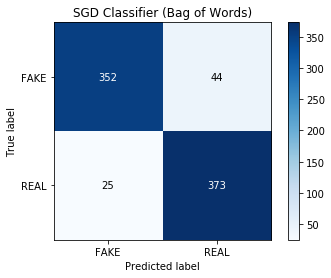

In [151]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

Adding stop words to the SGD classifier decreased accuracy by 0.06% and therefore will not be used.

In [154]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english")), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

accuracy 0.9408060453400504


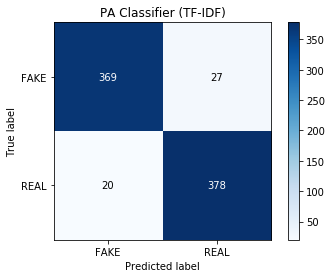

In [155]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

Adding stop words to the PA classifier increased accuracy by almost 1% and therefore will be used.

**Currently best performing model variantions**

- SGD baseline: ~91.9 % accuracy
- PA with stopwords: ~94.1% accuracy

## Adjusting the N-Gram Range

N-Grams are basically a set of co-occurring words within a given window and when computing the n-grams you typically move one word forward (although you can move X words forward in more advanced scenarios).

For example, for the sentence “The cow jumps over the moon”. If N=2 (known as bigrams), then the ngrams would be:

- the cow
- cow jumps
- jumps over
- over the
- the moon

If N=3, the n-grams would be:

- the cow jumps
- cow jumps over
- jumps over the
- over the moon

The idea is to use tokens such as bigrams in the feature space instead of just unigrams. 

(Source: https://kavita-ganesan.com/what-are-n-grams/#.XhHvshdKhQI)

In [68]:
def get_ngrams(text, n ):
    n_grams = ngrams(word_tokenize(text), n)
    return [ ' '.join(grams) for grams in n_grams]

Below you can find examples of bi-grams, tri-grams and four-grams for the second article of the dataset.

In [72]:
get_ngrams(train.total[1],2)[:5]

['Watch The', 'The Exact', 'Exact Moment', 'Moment Paul', 'Paul Ryan']

In [74]:
get_ngrams(train.total[1],3)[:5]

['Watch The Exact',
 'The Exact Moment',
 'Exact Moment Paul',
 'Moment Paul Ryan',
 'Paul Ryan Committed']

In [75]:
get_ngrams(train.total[1],4)[:5]

['Watch The Exact Moment',
 'The Exact Moment Paul',
 'Exact Moment Paul Ryan',
 'Moment Paul Ryan Committed',
 'Paul Ryan Committed Political']

### ngram_range = (1,2)

In [148]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer(ngram_range = (1,2))), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.9105793450881612


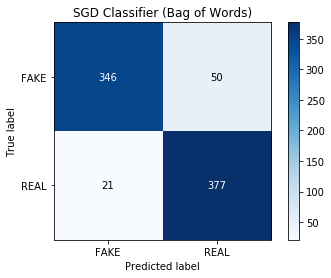

In [149]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [156]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english" ,ngram_range=(1,2))), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

accuracy 0.9382871536523929


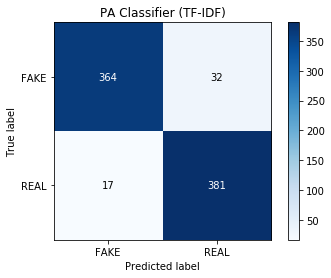

In [157]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

### ngram_range = (1,3)

In [146]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer(ngram_range = (1,3) )), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.9030226700251889


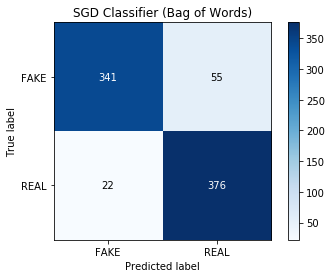

In [147]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [158]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english" ,ngram_range=(1,3))), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

accuracy 0.9319899244332494


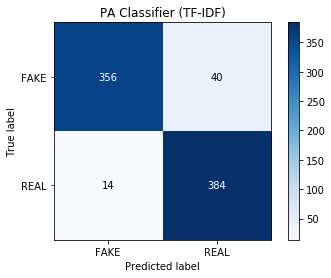

In [159]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

### ngram_range = (1,4)

In [152]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer(ngram_range = (1,4) )), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.8967254408060453


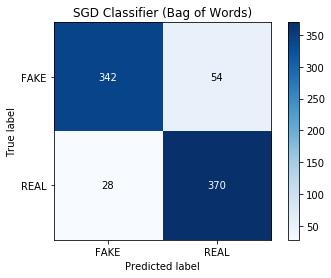

In [153]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [160]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english" ,ngram_range=(1,4))), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

accuracy 0.9282115869017632


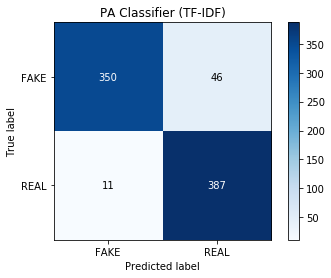

In [161]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

Increasing the N-Gram range up to 2, 3 or 4 consistently decreased accuracy and therewill will not be used.

**Currently best performing model variantions**

- SGD baseline: ~91.9 % accuracy
- PA with stopwords: ~94.1% accuracy

## Increasing Min/ Decreasing Max DF

By adjusting the document frequency, terms will be ignored that have a document frequncy higher or lower of the given threshold.

### min_df = 0.01

In [279]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer(min_df = 0.01)), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.9017632241813602


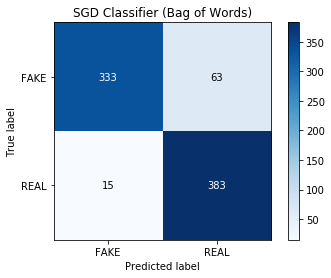

In [280]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [281]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english", min_df = 0.01)), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

accuracy 0.9282115869017632


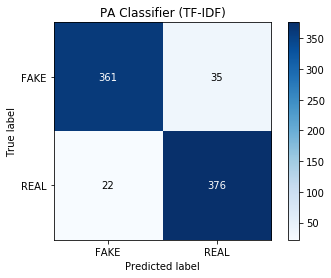

In [282]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

### min_df = 0.05

In [283]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer(min_df = 0.05)), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.707808564231738


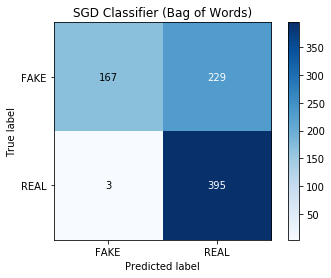

In [284]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [285]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english", min_df = 0.05)), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

accuracy 0.8740554156171285


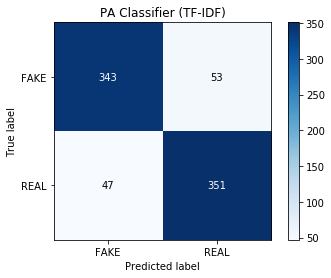

In [286]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

Increasing min/ decreasing max DF consistently decreased accuracy and will therefore not be used.

### max_df = 0.99

In [287]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer(max_df = 0.99)), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.9193954659949622


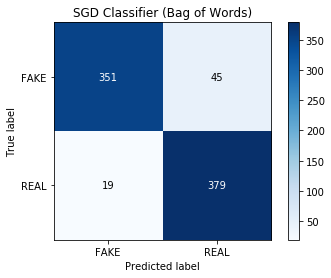

In [288]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [289]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english", max_df = 0.99)), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

accuracy 0.9408060453400504


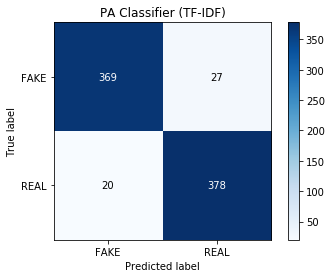

In [290]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

### max_df = 0.95

In [291]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer(max_df = 0.95)), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.9130982367758187


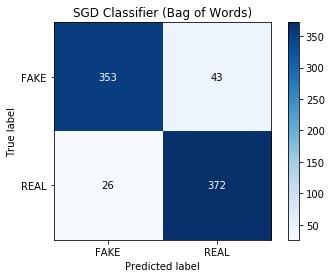

In [292]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [293]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english", max_df = 0.95)), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

accuracy 0.9408060453400504


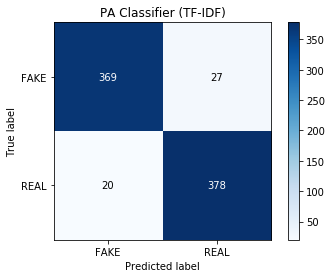

In [294]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

Increasing min/ decreasing max DF consistently decreased accuracy and will therefore not be used.

**Currently best performing model variantions**

- SGD baseline: ~91.9 % accuracy
- PA with stopwords: ~94.1% accuracy

## Stripping Accents & Normalizing Text

Stripping accents does exactly what it sounds like: it removes accents and in addition performs other text normalization during preprocessing.

"‘ascii’ is a fast method that only works on characters that have an direct ASCII mapping. ‘unicode’ is a slightly slower method that works on any characters. " https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
Below you can find an example of the usage of strip_accents.

In [112]:
vectorizer = TfidfVectorizer()
corpus = [
      'Thís is a cät.',
      'It likes to röäm in the gárden',
      ]
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names()

['cät', 'gárden', 'in', 'is', 'it', 'likes', 'röäm', 'the', 'thís', 'to']

In [113]:
vectorizer = TfidfVectorizer(strip_accents = 'ascii') #make object of Count Vectorizer
corpus = [
      'Thís is a cät.',
      'It likes to röäm in the gárden',
      ]
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names()

['cat', 'garden', 'in', 'is', 'it', 'likes', 'roam', 'the', 'this', 'to']

### ascii

In [174]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer(strip_accents = 'ascii')), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.9118387909319899


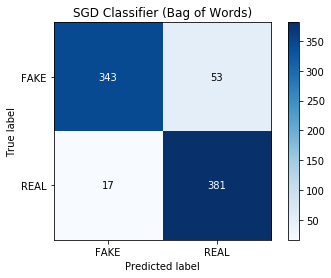

In [175]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [177]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english", strip_accents = 'ascii')), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

accuracy 0.9370277078085643


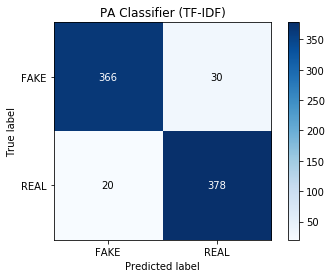

In [178]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

### Unicode

In [180]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer(strip_accents = 'unicode')), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.9156171284634761


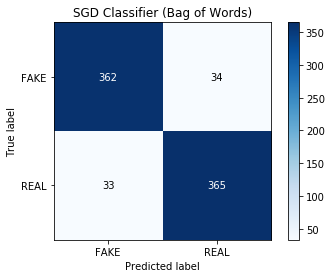

In [181]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [183]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english", strip_accents = 'unicode')), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

accuracy 0.9420654911838791


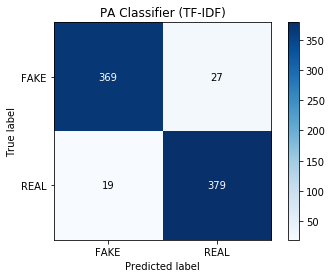

In [184]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

Removing accents with the unicode method from NFKD normalization improved the score for the PassiveAgressive classifier sslightly and will therefore be used.

**Currently best performing model variantions**

- SGD baseline: ~91.9 % accuracy
- PA with stopwords, unicode stripping and normalization,: ~94.2% accuracy

## Including the Lengths of Articles

As shown above, the average length of fake and news articles differs significantly. Therefore, I will tests if including the lengths of the article will increase accuracy.

In [180]:
def get_text_length(x):
    return np.array([len(t) for t in x]).reshape(-1, 1)

In [181]:
sgd_cnt_clf = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('vectorizer', CountVectorizer()),
            #('tfidf', TfidfTransformer()),
        ])),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ]))
    ])),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.6511335012594458


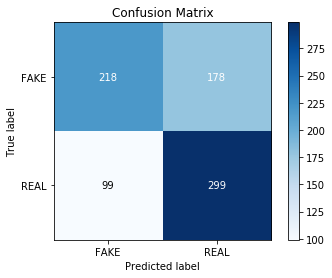

In [182]:
predicted = svm_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

In [184]:
pa_clf = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('vectorizer', TfidfVectorizer(stop_words = "english", strip_accents = 'unicode')),
            #('tfidf', TfidfTransformer()),
        ])),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ]))
    ])),
    ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

accuracy 0.4987405541561713


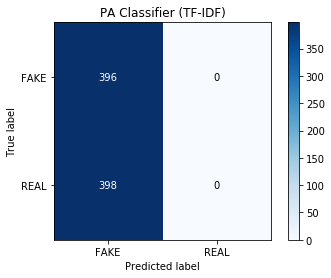

In [185]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

Including the length of articles decreased the accuracy for both classifiers and will therefore not be used. 

## Upweighting - Counting Title Twice

The logic behind counting the title twice is, that the title might include some predictive characteristics whether an article is fake news or not. One could argue that fake news titles tend to be more controversial in order to gain more clicks or to create more political entropy.

To upweigh the title, I simply created a new column and added the title twice to the text - "total2".
Having created the column "total2", I retrain our currently best performing models on "total2".

In [295]:
train["total2"] = train["title"] + train["total"]
test["total2"] = test["title"] + test["total"]

/Users/chrs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/chrs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [187]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer()), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total2, train.label)

accuracy 0.9193954659949622


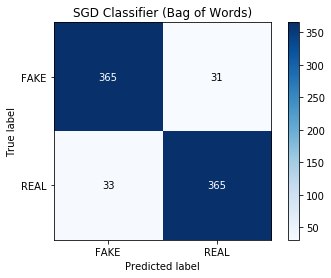

In [190]:
predicted = sgd_cnt_clf.predict(test.total2)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [191]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english", strip_accents = 'unicode')), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total2, train.label)

accuracy 0.9370277078085643


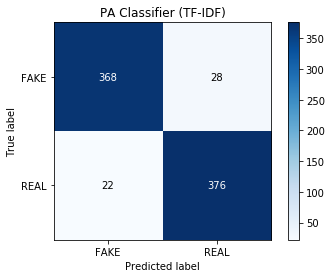

In [192]:
predicted = pa_clf.predict(test.total2)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

Weighing the title twice, reduced the accuracy for both the PA and did not change anything for the SGD. Consequently, counting the title twice will not be used moving forward.

**Currently best performing model variantions**

- SGD baseline: ~91.9 % accuracy
- PA with stopwords, unicode stripping and normalization,: ~94.2% accuracy

## Adding Stemmers

Stemming is the process of producing morphological variants of a root/base word. Stemming programs are commonly referred to as stemming algorithms or stemmers. A stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate” and “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”.

Some more example of stemming for root word "like" include:
- "likes"
- "liked"
- "likely"
- "liking"

Source: https://www.geeksforgeeks.org/introduction-to-stemming/

#### Snow Stemmer

In [239]:
def stemmer(df):
    stemmer = SnowballStemmer(language='english')
    df = df.apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split()]).lower())
    return df

In [240]:
sgd_cnt_clf = Pipeline([('snow_stem', FunctionTransformer(stemmer, validate=False)),
                     ('tfidf', CountVectorizer()), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.9093198992443325


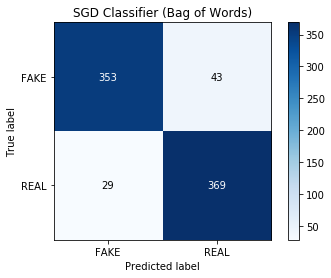

In [241]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [242]:
pa_clf = Pipeline([('snow_stem', FunctionTransformer(stemmer, validate=False)),
    ('vect', TfidfVectorizer(stop_words = "english", strip_accents = 'unicode')),
    ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_snow_clf.fit(train.total, train.label)

accuracy 0.9307304785894207


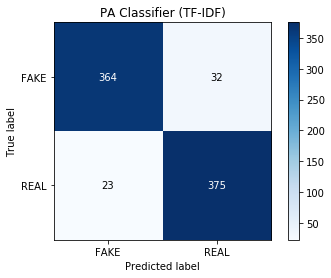

In [243]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

#### Port Stemmer

In [246]:
def stemmer(df):
    stemmer = PorterStemmer()
    df = df.apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split()]).lower())
    return df

In [247]:
sgd_cnt_clf = Pipeline([('port_stem', FunctionTransformer(stemmer, validate=False)),
                     ('tfidf', CountVectorizer()), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.9030226700251889


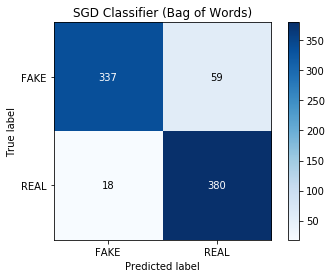

In [248]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [249]:
pa_clf = Pipeline([('port_stem', FunctionTransformer(stemmer, validate=False)),
    ('vect', TfidfVectorizer(stop_words = "english", strip_accents = 'unicode')),
    ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])


pa_clf = pa_port_clf.fit(train.total, train.label)

accuracy 0.9307304785894207


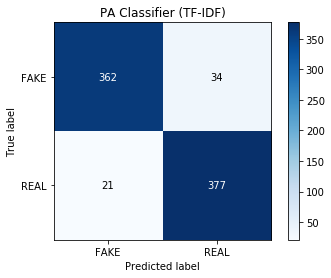

In [250]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

Neither for the SGD Classifier nor the PA Classifier did stemming improve the accuracy. Consequently, stemming will not be used. 

**Currently best performing model variantions**

- SGD baseline: ~91.9 % accuracy
- PA with stopwords, unicode stripping and normalization,: ~94.2% accuracy

## Adding a Lemmatizer

"Stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma." Source: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [305]:
def lemmatizer(df):
    lemmatizer = WordNetLemmatizer()
    df = df.apply(lambda x: " ".join([lemmatizer.lemmatize(i) for i in re.sub("[^a-zA-Z]", " ", x).split()]).lower())
    return df

In [306]:
sgd_cnt_clf = Pipeline([('port_stem', FunctionTransformer(stemmer, validate=False)),
                     ('tfidf', CountVectorizer()), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.9093198992443325


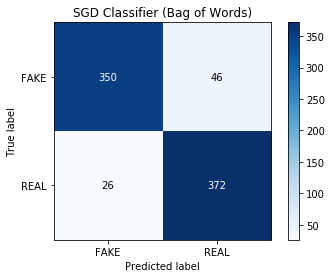

In [307]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [308]:
pa_clf = Pipeline([('port_stem', FunctionTransformer(stemmer, validate=False)),
    ('vect', TfidfVectorizer(stop_words = "english", strip_accents = 'unicode')),
    ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])


pa_clf = pa_port_clf.fit(train.total, train.label)

accuracy 0.9307304785894207


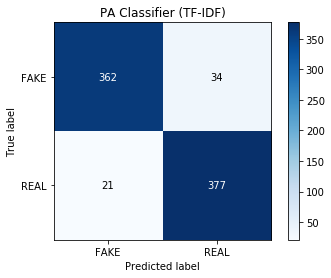

In [309]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

Neither for the SGD Classifier nor the PA Classifier did lemmatizing improve the accuracy. Consequently, lemmatization will not be used. 

**Currently best performing model variantions**

- SGD baseline: ~91.9 % accuracy
- PA with stopwords, unicode stripping and normalization,: ~94.2% accuracy

## Testing other Tokenizers

Tokenization is the process of splitting up either sentences or words of document so that vectorizers can calculate the frequencies of words. The method CountVectorizer() and TfidfVectorizer() both come with default vectorizer but in fact there is a multitude of different vectorizers out there which all use a different methods to tokenize a document. In the following, I will test different tokenizers to see if the accuracy can further be improved.

### nltk word_tokenize

In [251]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer(tokenizer = word_tokenize)), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.9206549118387909


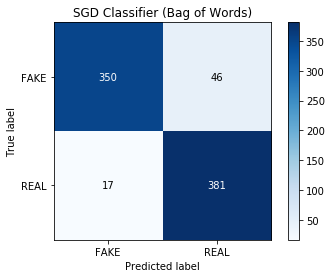

In [253]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [254]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english", strip_accents = 'unicode', tokenizer = word_tokenize)), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

accuracy 0.9445843828715366


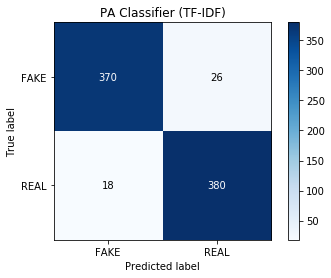

In [256]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

### nltk RegexpTokenizer

In [216]:
regex_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [258]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer(tokenizer = regex_tokenizer.tokenize)), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.9256926952141058


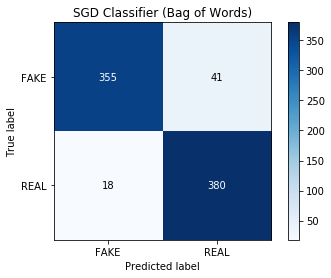

In [260]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [261]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english", strip_accents = 'unicode', tokenizer = regex_tokenizer.tokenize)), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

accuracy 0.9496221662468514


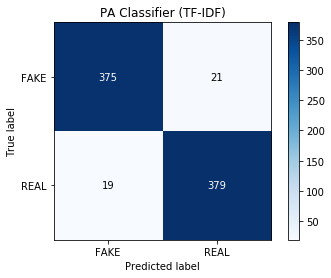

In [263]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

### Treebank Tokenizer

In [264]:
treebank = TreebankWordTokenizer()

In [265]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer(tokenizer = treebank.tokenize)), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.9206549118387909


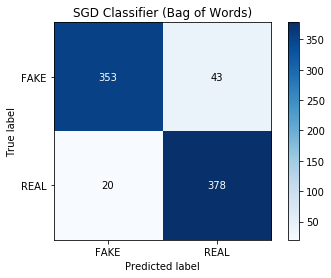

In [267]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [268]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english", strip_accents = 'unicode', tokenizer = treebank.tokenize)), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

accuracy 0.9382871536523929


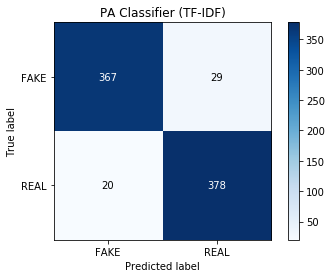

In [270]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

For both the SGD and PA classifier the regexp tokenizer performerd the best.

**Currently best performing model variantions**

- SGD with regexp tokenizer: ~92.6 % accuracy
- PA with stopwords, unicode stripping and normalization and regexp tokenizer: ~95% accuracy

## Trying Spacy Tokenizers

### Spacy Tokenizer I

In [382]:
def custom_tok1(text):
    nlp = spacy.load("en_core_web_sm")
    return [token.lemma_.lower().strip() + token.pos_ for token in nlp(text)]

In [383]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer(tokenizer = custom_tok1)), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.9269521410579346


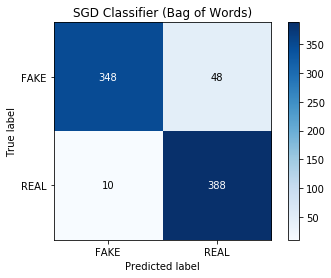

In [384]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [385]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english", strip_accents = 'unicode', tokenizer = custom_tok1)), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

/Users/chrs/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-pron-DET', '-pron-PRON', 'aX', 'aboutADP', 'aboveADP', 'acrossADP', 'afterADP', 'afterwardsADV', 'againADV', 'againstADP', 'allDET', 'almostADV', 'aloneADV', 'alongADP', 'alreadyADV', 'alsoADV', 'althoughSCONJ', 'alwaysADV', 'amongADP', 'amongstADP', 'amoungstPROPN', 'amountNOUN', 'anDET', 'andCCONJ', 'anotherDET', 'anyDET', 'anyhowADV', 'anyonePRON', 'anythingPRON', 'anywayINTJ', 'anywhereADV', 'aroundADP', 'asSCONJ', 'atADP', 'backADV', 'beAUX', 'becauseSCONJ', 'becomeVERB', 'beforeADP', 'beforehandADV', 'behindADP', 'belowADP', 'besideADP', 'besidesSCONJ', 'betweenADP', 'beyondADP', 'billPROPN', 'bothDET', 'bottomNOUN', 'butCCONJ', 'byADP', 'callNOUN', 'canVERB', 'coPROPN', 'conX', 'couldVERB', 'cryVERB', 'dePROPN', 'describeVERB', 'detailNOUN', 'doAUX', 'doVERB', 'downADP', '

accuracy 0.9408060453400504


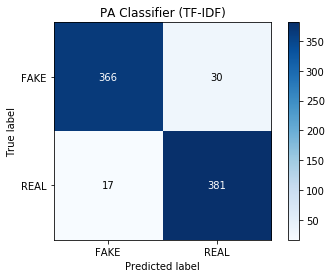

In [386]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

### Spacy Tokenizer II With Lemmatization

In [387]:
def custom_tok2(text):
    nlp = spacy.load("en_core_web_sm")
    return [token.lemma_.lower().strip() + token.pos_ for token in nlp(text)
        if 
            not token.is_stop and not nlp.vocab[token.lemma_].is_stop
            and not token.is_punct
            and not token.is_digit
    ]

In [388]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer(tokenizer = custom_tok2)), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

accuracy 0.9118387909319899


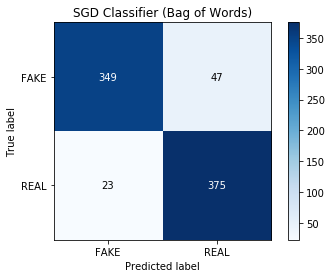

In [389]:
predicted = sgd_cnt_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "SGD Classifier (Bag of Words)")

In [390]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english", strip_accents = 'unicode', tokenizer = custom_tok2)), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

/Users/chrs/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amoungstPROPN', 'billPROPN', 'coPROPN', 'conX', 'cryVERB', 'dePROPN', 'describeVERB', 'detailNOUN', 'egPROPN', 'etcX', 'fillPROPN', 'findVERB', 'fireNOUN', 'iePROPN', 'incPROPN', 'interestNOUN', 'ltdPROPN', 'millPROPN', 'sincereADJ', 'systemNOUN', 'thickADJ', 'thinADJ', 'unPROPN'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


accuracy 0.9231738035264484


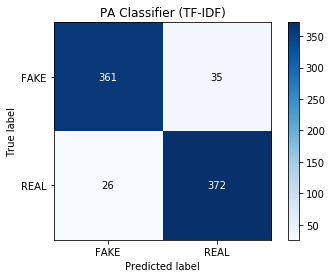

In [391]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'], title = "PA Classifier (TF-IDF)")

---

# Cross Validation

In order to make sure that the results of our models can be generalized it is not enough to split the dataset in training and test data but they must be cross-validated. By cross-validating, we are making sure that the model did not just got a lucky score once but consistently performs around the same score, when given new data.

## SGD

In [318]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer(tokenizer = regex_tokenizer.tokenize)), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

In [319]:
predicted = sgd_cnt_clf.predict(test.total)
accuracy_sgd_cnt_clf = np.mean(predicted == test.label)
accuracy_sgd_cnt_clf

0.9256926952141058

In [320]:
sgd_cv_scores = cross_val_score(sgd_cnt_clf, train.total, train.label, cv=5)
sgd_cv_scores

array([0.90393701, 0.92440945, 0.91955836, 0.89432177, 0.91798107])

## PA

In [321]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english", strip_accents = 'unicode', tokenizer = regex_tokenizer.tokenize)), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

In [322]:
predicted = pa_clf.predict(test.total)
accuracy_pa_clf = np.mean(predicted == test.label)
accuracy_pa_clf

0.9496221662468514

In [323]:
pa_cv_scores = cross_val_score(pa_clf, train.total, train.label, cv=5)
pa_cv_scores

array([0.92440945, 0.95433071, 0.94794953, 0.93690852, 0.94794953])

The scores are robust,potentially a bit lower which can be explained since the trainset in CV is smaller than during the initial training phase.

---

# Grid Search

To find the optimal hyperparameters of each algorithm, we are going to perform a hyperparameter search.

## SGD

In [259]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer(tokenizer = regex_tokenizer.tokenize)), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

In [319]:
predicted = sgd_cnt_clf.predict(test.total)
accuracy_sgd_cnt_clf = np.mean(predicted == test.label)
accuracy_sgd_cnt_clf

0.9256926952141058

In [261]:
parameters_sgd = {'clf__alpha': (5e-1, 5e-1, 5e-2, 1e-2,5e-3, 1e-3, 5e-4, 1e-4),
                  'clf__max_iter': (1000, 2000)
}


In [325]:
gs_sgd = GridSearchCV(sgd_cnt_clf, parameters_sgd, n_jobs=-1)

In [326]:
gs_sgd = gs_sgd.fit(train.total, train.label)

/Users/chrs/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [327]:
gs_sgd.best_score_

0.9183480453972257

In [328]:
gs_sgd.best_params_

{'clf__alpha': 0.05, 'clf__max_iter': 1000}

In [329]:
sgd_cnt_clf = Pipeline([('tfidf', CountVectorizer()), 
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=0.05, max_iter = 10000, random_state=KEYS["SEED"]))])

sgd_cnt_clf = sgd_cnt_clf.fit(train.total, train.label)

In [330]:
predicted = sgd_cnt_clf.predict(test.total)
accuracy_sgd_cnt_clf = np.mean(predicted == test.label)
accuracy_sgd_cnt_clf

0.9193954659949622

In [262]:
search = GridSearchCV(sgd_cnt_clf, parameters_sgd, n_jobs=-1)
search.fit(train.total, train.label)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

/Users/chrs/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameter (CV score=0.918):
{'clf__alpha': 0.05, 'clf__max_iter': 1000}


## PA

In [263]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english", strip_accents = 'unicode', tokenizer = regex_tokenizer.tokenize)), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3))])

pa_clf = pa_clf.fit(train.total, train.label)

In [322]:
predicted = pa_clf.predict(test.total)
accuracy_pa_clf = np.mean(predicted == test.label)
accuracy_pa_clf

0.9496221662468514

In [264]:
parameters_pa = {'clf__max_iter': (1000, 2000, 3000),
                    'clf__tol': (0.0001, 0.001, 0.01, 1,),
                    'clf__loss': ('hinge', 'squared_hinge'),
                    'clf__C': (0.1, 0.3, 0.5, 0.7, 1, 1.3, 1.5, 1.7, 2.0),
                    'clf__fit_intercept': (True, False)
}


In [374]:
gs_pa = GridSearchCV(pa_clf, parameters_pa, n_jobs=-1)

In [375]:
gs_pa = gs_pa.fit(train.total, train.label)

/Users/chrs/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [376]:
gs_pa.best_score_

0.9413619167717528

In [377]:
gs_pa.best_params_

{'clf__C': 0.5,
 'clf__fit_intercept': True,
 'clf__loss': 'hinge',
 'clf__max_iter': 1000,
 'clf__tol': 0.0001}

In [217]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english", strip_accents = 'unicode', tokenizer = regex_tokenizer.tokenize)), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=0.0001, fit_intercept = True, C = 0.5, loss = 'hinge', ))])

pa_clf = pa_clf.fit(train.total, train.label)

In [218]:
predicted = pa_clf.predict(test.total)
accuracy_pa_clf = np.mean(predicted == test.label)
accuracy_pa_clf

0.9559193954659949

In [265]:
search = GridSearchCV(pa_clf, parameters_pa, n_jobs=-1)
search.fit(train.total, train.label)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

/Users/chrs/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameter (CV score=0.941):
{'clf__C': 0.5, 'clf__fit_intercept': True, 'clf__loss': 'hinge', 'clf__max_iter': 1000, 'clf__tol': 0.0001}


**Best Performing Model**

After our extensive optimization we found the model that performs the best:

pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english", strip_accents = 'unicode', tokenizer = regex_tokenizer.tokenize)), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=0.0001, fit_intercept = True, C = 0.5, loss = 'hinge', ))])

                     
With an CV accuracy of 0.941. For our test set I expect the score to be slightly higher, as the final models will be trained on all of the train.

accuracy 0.9559193954659949


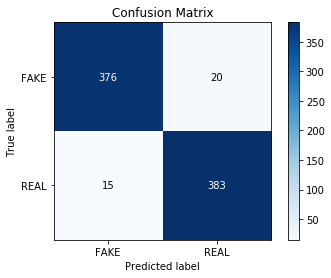

In [380]:
predicted = pa_clf.predict(test.total)
acc_score = accuracy_score(test.label, predicted)
print("accuracy",  acc_score)
plot_confusion_matrix(test.label, predicted, labels=['FAKE', 'REAL'])

---

# Model Explanation

Below we inspect the top 30 vectors that affect the outcome whether news are supposed to be real or fake the most.

In [381]:
eli5.show_weights(pa_clf, top=30, target_names=train.label)

Weight?,Feature
+3.767,'s
+3.298,--
+3.112,said
+2.693,","""
+2.591,"."""
+2.533,cruz
+2.503,debate
+2.078,says
+2.062,—
+1.999,gop


From the first look no obvious trend can be identified that fake or real news would make intensified use of a specific topic or kind of words. In addition, there are a lot of punctuates that cannot be interpreted at all. 

In [226]:
test["predicted"] = predicted
test.head()

/Users/chrs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,ID,title,text,label,total,text_length,title_length,predicted
149,6212,"Re: If Donald Trump Wins, He Will Be 70 Years,...",Archives Michael On Television If Donald Trump...,FAKE,"Re: If Donald Trump Wins, He Will Be 70 Years,...",5896,102,FAKE
1783,9589,Comment on 21 Things We’ve Learned About Hilla...,"Posted on October 28, 2016 by Daisy Luther \nL...",FAKE,Comment on 21 Things We’ve Learned About Hilla...,11462,122,FAKE
3674,4022,Russia carries out new airstrikes in Syria,"(CNN) Russia's airstrikes in Syria ""do not go ...",REAL,Russia carries out new airstrikes in Syria(CNN...,7251,42,REAL
724,5728,Former Director Of National Budget Warns That ...,Former Director of the Office of Management an...,FAKE,Former Director Of National Budget Warns That ...,201,81,FAKE
327,8197,BREAKING : TED CRUZ CALLS FOR SPECIAL PROSECUT...,BREAKING : TED CRUZ CALLS FOR SPECIAL PROSECUT...,FAKE,BREAKING : TED CRUZ CALLS FOR SPECIAL PROSECUT...,1308,83,FAKE


In [227]:
test[test["predicted"]=="REAL"]["text_length"].mean()

5674.761786600497

In [228]:
test[test["predicted"]=="FAKE"]["text_length"].mean()

4189.168797953964

Interestingly, even though parsing the length of each article as a feature to the classifiers worsened accuracy, the average length of fake and real news keeps to be quite significant.

# Final Prediction

Finally, I will train the model on the whole train dataset and predict the test set.

In [229]:
df.head()

,ID,title,text,label,total,text_length,title_length
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,"You Can Smell Hillary’s FearDaniel Greenfield,...",7518,28
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,2646,85
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathyU.S...,2543,43
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,Bernie supporters on Twitter erupt in anger ag...,2660,84
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,The Battle of New York: Why This Primary Matte...,1840,48


In [237]:
df_test = pd.read_csv("fake_or_real_news_test.csv") 
df_test.head()

,ID,title,text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...


In [238]:
df_test["total"] = df_test["title"] + df_test["text"]
df_test.head()

,ID,title,text,total
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,September New Homes Sales Rise——-Back To 1992 ...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,Why The Obamacare Doomsday Cult Can't Admit It...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,"Sanders, Cruz resist pressure after NY losses,..."
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,Surviving escaped prisoner likely fatigued and...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,Clinton and Sanders neck and neck in Californi...


In [287]:
pa_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words = "english", strip_accents = 'unicode', tokenizer = regex_tokenizer.tokenize)), 
                     ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=0.0001, fit_intercept = True, C = 0.5, loss = 'hinge', ))])

pa_clf = pa_clf.fit(df.total, df.label)

In [288]:
predicted = pa_clf.predict(df_test.total)

In [289]:
predictions_only = pd.DataFrame(predicted, columns=['predictions']).to_csv('predictions_only_ChristophStehling.csv')

In [290]:
df_test["predictions"] = predicted
df_test.to_csv('df_test_predictions_ChristophStehling.csv')

# Future Work

As it can be seen above, among the most informative vevctors are signs such as "--", ","", "--", "-", "...", ":", etc. Obviously, these are not very informative, especially since they appear to be important both for fake and real news. Future work should examine why those signs are appearing among the most important vectors and whether the result can be made more explainable by using another tokenizer or adjusting the regexp tokenizer used in this work.

It might also be worth to examine why including the length of articles worsened the score for SGD classifier by almost 30% and led the PassiveAgrressive classifier to classify everything as fake.

# Sources of Inspiration

The following kernels and posts have served as sources of inspiration during this project and provide further material to dive into the topic of fake news detection:
- https://towardsdatascience.com/top-5-natural-language-processing-python-libraries-for-data-scientist-32463d36feae
- https://www.kaggle.com/akoury/nlp-for-fake-news-classification
- https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976
- https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a 
- https://github.com/erfannoury/TextClassification/blob/master/sklearn-text%20classification.ipynb 
- https://github.com/javedsha/text-classification/blob/master/Text%2BClassification%2Busing%2Bpython%2C%2Bscikit%2Band%2Bnltk.py
- https://github.com/nishitpatel01/Fake_News_Detection
- https://github.com/cw-ashutoshdwivedi/Fake-News-Detector-Using-NLP/blob/master/Fake_News.ipynb
- https://www.kaggle.com/akoury/nlp-for-fake-news-classification/notebook
- https://stackoverflow.com/questions/39121104/how-to-add-another-feature-length-of-text-to-current-bag-of-words-classificati